In [40]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 读取数据集
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print("训练集形状:", train_data.shape)
print("测试集形状:", test_data.shape)
print("\n训练集前5行:")
print(train_data.head())

训练集形状: (891, 12)
测试集形状: (418, 11)

训练集前5行:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0    

In [41]:
# 数据预处理
def preprocess_data(data, is_train=True):
    # 复制数据避免修改原始数据
    df = data.copy()
    
    # 处理缺失值 - 使用.loc方法避免链式赋值警告
    age_median = df['Age'].median()
    df.loc[:, 'Age'] = df['Age'].fillna(age_median)
    
    if is_train:
        embarked_mode = df['Embarked'].mode()[0]
        df.loc[:, 'Embarked'] = df['Embarked'].fillna(embarked_mode)
    else:
        # 对于测试集，使用训练集的众数
        train_embarked_mode = train_data['Embarked'].mode()[0]
        df.loc[:, 'Embarked'] = df['Embarked'].fillna(train_embarked_mode)
    
    fare_median = df['Fare'].median()
    df.loc[:, 'Fare'] = df['Fare'].fillna(fare_median)
    
    # 从姓名中提取称谓
    df.loc[:, 'Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df.loc[:, 'Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                       'Jonkheer', 'Dona'], 'Other')
    df.loc[:, 'Title'] = df['Title'].replace('Mlle', 'Miss')
    df.loc[:, 'Title'] = df['Title'].replace('Ms', 'Miss')
    df.loc[:, 'Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # 创建新特征
    df.loc[:, 'FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df.loc[:, 'IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # 对分类变量进行手动编码
    # 性别编码
    df.loc[:, 'Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    # 登船港口编码
    embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
    df.loc[:, 'Embarked'] = df['Embarked'].map(embarked_mapping)
    
    # 称谓编码
    title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Other': 4}
    df.loc[:, 'Title'] = df['Title'].map(title_mapping)
    
    # # 选择用于训练的特征
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                'Embarked', 'Title', 'FamilySize', 'IsAlone']
    # features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',  
    #               'FamilySize', 'IsAlone']
    
    X = df[features].values
    
    # 手动标准化数值特征
    numerical_features = ['Age', 'FamilySize']
    for feature in numerical_features:
        feature_idx = features.index(feature)
        mean_val = X[:, feature_idx].mean()
        std_val = X[:, feature_idx].std()
        if std_val > 0:
            X[:, feature_idx] = (X[:, feature_idx] - mean_val) / std_val
    
    # 确保X是float32类型
    X = X.astype(np.float32)

    if is_train:
        y = df['Survived'].values
        return X, y
    else:
        return X

# 预处理训练数据和测试数据
X_train, y_train = preprocess_data(train_data, is_train=True)
X_test = preprocess_data(test_data, is_train=False)

print(f"训练特征矩阵形状: {X_train.shape}")
print(f"训练标签形状: {y_train.shape}")
print(f"测试特征矩阵形状: {X_test.shape}")

print("\n训练特征矩阵形状:")
print(X_train[0])

训练特征矩阵形状: (891, 10)
训练标签形状: (891,)
测试特征矩阵形状: (418, 10)

训练特征矩阵形状:
[ 3.          0.         -0.5657365   1.          0.          7.25
  0.          0.          0.05915987  0.        ]


In [42]:
# 定义PyTorch数据集
class TitanicDataset(Dataset):
    def __init__(self, features, labels=None, is_train=True):
        # 确保features是数值类型
        features = features.astype(np.float32)
        self.features = torch.FloatTensor(features)
        self.is_train = is_train
        if is_train:
            self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.is_train:
            return self.features[idx], self.labels[idx]
        else:
            return self.features[idx]

# 划分训练集和验证集
from torch.utils.data import SubsetRandomSampler

# 检查数据类型
print("X_train 数据类型:", X_train.dtype)
print("X_train 示例数据:")
print(X_train[:5])

# 如果X_train包含对象类型，需要转换为float类型
if X_train.dtype == 'object':
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

# 创建随机索引用于划分训练集和验证集
dataset_size = len(X_train)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))  # 20%作为验证集
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# 创建数据加载器
train_dataset = TitanicDataset(X_train, y_train, is_train=True)
val_dataset = TitanicDataset(X_train, y_train, is_train=True)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, sampler=val_sampler)

# 定义深度学习模型
class TitanicNet(nn.Module):
    def __init__(self, input_size):
        super(TitanicNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# 初始化模型、损失函数和优化器
input_size = X_train.shape[1]
model = TitanicNet(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("模型结构:")
print(model)

X_train 数据类型: float32
X_train 示例数据:
[[ 3.0000000e+00  0.0000000e+00 -5.6573647e-01  1.0000000e+00
   0.0000000e+00  7.2500000e+00  0.0000000e+00  0.0000000e+00
   5.9159875e-02  0.0000000e+00]
 [ 1.0000000e+00  1.0000000e+00  6.6386104e-01  1.0000000e+00
   0.0000000e+00  7.1283302e+01  1.0000000e+00  2.0000000e+00
   5.9159875e-02  0.0000000e+00]
 [ 3.0000000e+00  1.0000000e+00 -2.5833708e-01  0.0000000e+00
   0.0000000e+00  7.9250002e+00  0.0000000e+00  1.0000000e+00
  -5.6097484e-01  1.0000000e+00]
 [ 1.0000000e+00  1.0000000e+00  4.3331149e-01  1.0000000e+00
   0.0000000e+00  5.3099998e+01  0.0000000e+00  2.0000000e+00
   5.9159875e-02  0.0000000e+00]
 [ 3.0000000e+00  0.0000000e+00  4.3331149e-01  0.0000000e+00
   0.0000000e+00  8.0500002e+00  0.0000000e+00  0.0000000e+00
  -5.6097484e-01  1.0000000e+00]]
模型结构:
TitanicNet(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_feat

开始训练模型...
Epoch [10/120], Train Loss: 0.5793, Val Loss: 0.5606, Train Acc: 67.74%, Val Acc: 67.42%
Epoch [20/120], Train Loss: 0.5177, Val Loss: 0.4657, Train Acc: 75.46%, Val Acc: 77.53%
Epoch [30/120], Train Loss: 0.4950, Val Loss: 0.4433, Train Acc: 80.36%, Val Acc: 79.21%
Epoch [40/120], Train Loss: 0.4878, Val Loss: 0.4536, Train Acc: 80.22%, Val Acc: 80.34%
Epoch [50/120], Train Loss: 0.4640, Val Loss: 0.4369, Train Acc: 81.07%, Val Acc: 80.34%
Epoch [60/120], Train Loss: 0.4400, Val Loss: 0.4206, Train Acc: 81.35%, Val Acc: 80.34%
Epoch [70/120], Train Loss: 0.4295, Val Loss: 0.4239, Train Acc: 83.31%, Val Acc: 82.02%
Epoch [80/120], Train Loss: 0.4225, Val Loss: 0.4160, Train Acc: 82.75%, Val Acc: 80.34%
Epoch [90/120], Train Loss: 0.4470, Val Loss: 0.4096, Train Acc: 82.33%, Val Acc: 82.02%
Epoch [100/120], Train Loss: 0.4380, Val Loss: 0.3983, Train Acc: 83.03%, Val Acc: 81.46%
Epoch [110/120], Train Loss: 0.4147, Val Loss: 0.4002, Train Acc: 84.29%, Val Acc: 81.46%
Epoch [12

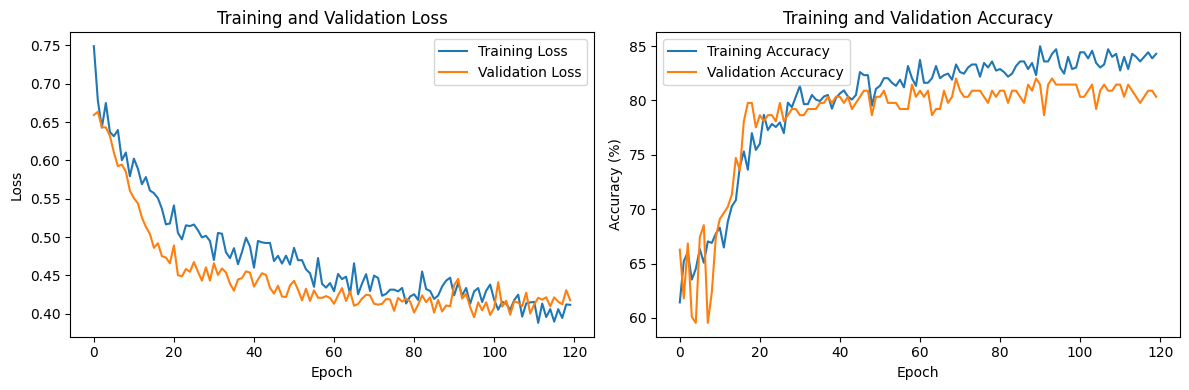

预测结果前10行:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0
提交文件已保存为 submission.csv

最终验证集准确率: 80.34%


In [43]:
# 训练模型
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # 记录损失和准确率
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        train_accuracies.append(100 * train_correct / train_total)
        val_accuracies.append(100 * val_correct / val_total)
        
        # 每10个epoch打印一次信息
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, '
                  f'Train Acc: {train_accuracies[-1]:.2f}%, '
                  f'Val Acc: {val_accuracies[-1]:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# 开始训练
print("开始训练模型...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=120)

# 绘制训练曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# 在测试集上进行预测
def predict_test_data(model, X_test):
    # 转换为PyTorch张量
    X_test_tensor = torch.FloatTensor(X_test)
    
    # 预测
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.numpy()

# 生成预测结果
test_predictions = predict_test_data(model, X_test)

# 创建提交文件
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})

print("预测结果前10行:")
print(submission.head(10))

# 保存提交文件
submission.to_csv('submission.csv', index=False)
print("提交文件已保存为 submission.csv")

# 显示最终验证准确率
final_val_accuracy = val_accuracies[-1]
print(f"\n最终验证集准确率: {final_val_accuracy:.2f}%")